In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import os
from dotmap import DotMap
from tqdm import tqdm
from PIL import Image, ImageOps, ImageFilter
from torchvision import transforms
from copy import deepcopy

sys.path.append("/home/warburg/repo/bayesian-metric-learning/src")
sys.path.append("/home/warburg/repo/bayesian-metric-learning/stochman")

from datasets.cub200 import TestDataset
from models import configure_model
from evaluate.ranking import compute_rank
from evaluate.evaluate import evaluate
from evaluate.utils import get_pos_idx, get_pos_idx_place_recognition, remove_duplicates
from stochman.laplace import DiagLaplace
from stochman.utils import convert_to_stochman
from torch.nn.utils import parameters_to_vector, vector_to_parameters

In [9]:
args = {"dataset": "cub200", 
        "resume": "../lightning_logs/cub200/laplace_online/1/contrastive/full/checkpoints/best-v1.ckpt",
        "data_dir": "/home/warburg/data",        
        "arch": "resnet50", 
        "pool": "gem",
        "whitening": True, 
        "pretrained": True, 
        "dropout_rate": 0.0, 
        "latent_dim": 512}
args = DotMap(args)

In [15]:
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)
transform = transforms.ToPILImage()

In [10]:
def rename_keys(statedict):

    new_dict = {k.replace("model.", ""): statedict[k] for k in statedict.keys() if "hessian" != k}
    return new_dict


model = configure_model(args)
statedict = torch.load(args.resume, map_location="cpu")["state_dict"]
hessian = statedict["hessian"].cuda()
statedict = rename_keys(statedict)
model.load_state_dict(statedict)
model.eval()
model = model.cuda()

>> Using pre-trained model 'resnet50'


In [11]:
data = TestDataset(args.data_dir)

data.transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(227),
                #transforms.ToTensor(),
                #transforms.Normalize(
                #    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                #),
            ]
        )

normalize = transforms.Compose(
            [
                #transforms.Resize(256),
                #transforms.CenterCrop(227),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

In [12]:
def forward(model, hessian, laplace, x, n_samples=1):

    x = model.backbone(x)
    if hasattr(model, "pool"):
        x = model.pool(x)

    # get mean and std of posterior
    mu_q = parameters_to_vector(model.linear.parameters()).unsqueeze(1)
    hessian = torch.relu(hessian)
    sigma_q = laplace.posterior_scale(hessian)

    # draw samples
    samples = laplace.sample(mu_q, sigma_q, n_samples)

    # forward n times
    zs = []
    for net_sample in samples:

        # replace the network parameters with the sampled parameters
        vector_to_parameters(net_sample, model.linear.parameters())

        z = model.linear(x)

        zs.append(z)

    zs = torch.stack(zs)

    # compute statistics
    z_mu = zs.mean(dim=0)
    z_sigma = zs.std(dim=0)

    # put mean parameters back
    vector_to_parameters(mu_q, model.linear.parameters())

    return {"z_mu": z_mu, "z_sigma": z_sigma, "z_samples": zs.permute(1, 0, 2)}

In [13]:
laplace = DiagLaplace()

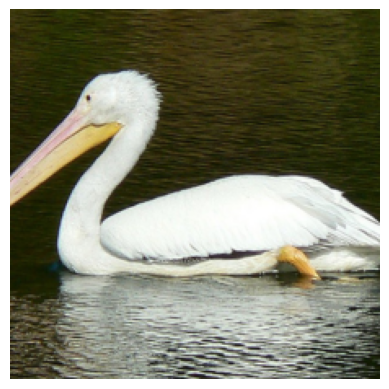

In [73]:
x, target = data.__getitem__(1)

plt.imshow(x)
plt.axis("off")
plt.show()

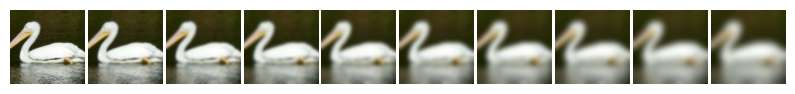

In [92]:
variance = []
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
aug = "blur"
for i in range(10):

    x = data.__getitem__(1)[0]

    #rotate = transforms.RandomRotation(i*5)
    
    # guassian blur
    if aug == "blur":
        x = x.filter(ImageFilter.GaussianBlur(i * 1 + 1))
        x = normalize(x)

    elif aug == "noise":
        x = normalize(x)
        x = x + torch.randn_like(x) * (i + 0.4)

    elif aug == "boxes":
        x = normalize(x)
        np.random.seed(43)
        for j in range(i):
            a, b = np.random.randint(0, 227, size=2)
            x[:, a:a+100, b:b+100] = 0

    elif aug == "scale":
        # scale
        print(int(227 * (i * 1)))
        scale = transforms.Resize((int(227 * (1 + i * 0.1))))
        
        x = scale(x)
        x = normalize(x)
        x_new = torch.zeros(3, 227, 227)
        _, H, W = x_new.shape
        c, h, w = x.shape
        pad_h = H - h
        pad_w = W - w
        
        x_new[:, pad_h//2:pad_h//2 + h, pad_w//2:pad_w//2 + w] = x
        x = deepcopy(x_new)
    
    x = x.cuda()
    with torch.no_grad():
        output = forward(model, hessian, laplace, x.unsqueeze(0), 100)

    # ensure that features are l2 normalized
    z_mu = output["z_mu"]
    z_mu = z_mu / torch.norm(z_mu, dim=-1, keepdim=True)

    o = {"z_mu": z_mu.cpu()}
    o["label"] = target

    if "z_sigma" in output:
        o["z_sigma"] = output["z_sigma"]

    if "z_samples" in output:
        z_samples = output["z_samples"]
        # ensure that samples are also l2 normalize
        z_samples = z_samples / torch.norm(z_samples, dim=-1, keepdim=True)
        o["z_samples"] = z_samples

    variance.append(o["z_sigma"].sum().item())

    x = inv_normalize(x)
    x = torch.clamp(x, 0, 1)
    x = x.cpu().permute(1, 2, 0).numpy()
    
    ax[i].imshow(x)
    ax[i].axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

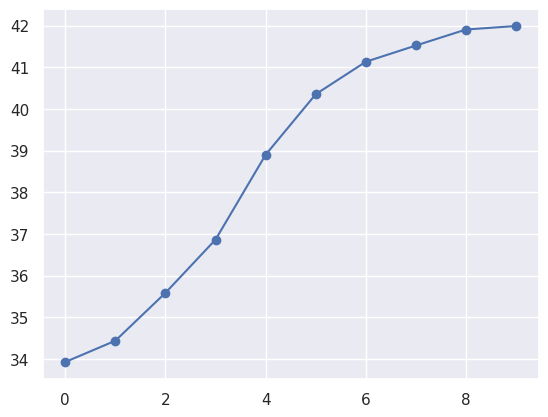

In [89]:
plt.plot(variance, '-o')